[View in Colaboratory](https://colab.research.google.com/github/rahutchinson/StudentLoanPaymentSandbox/blob/master/StudnetLoanPaymentCalculator.ipynb)

# Student Loan Most Efficient Pay Off Schedule

####Paying off highest rate **VS** Paying off highest daily cost

#####Background
This project was motivated by many people saying that the best possible way to pay off debt is the throw all you can at the highest interest rate that you have. Here is the mathmatical proof that although that is true most of the time, it is not always. 

#####Algorithms
The solution that I found that saved me $12 was to throw all your money at the debt that is costing you the most per day. So the intrest rate/365 * principal. You can see all of this below. 

# Setup


You need the basics. 

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


#Debt Group Definition

In [0]:
class Group:
  def __init__(self, group_name,group_rate,group_princp, _active, _min_pay):
    self.name = group_name
    self.rate = group_rate
    self.active = _active
    self.daily_rate = group_rate/365.25
    self.principal = group_princp
    self.history = pd.DataFrame(index=range(0,1095), columns=['Principal', 'Day Cost'])
    self.day = 0
    self.min_pay = _min_pay
    self.payments = []
    self.done = 0
    
    """
     This function calculates and adds the daily interest for the object.
     
    """
  def add_daily_interest(self):
    if(self.active):
      self.principal = round((self.principal + (self.principal * self.daily_rate)),2)
      
    """
     This function pays the minimum payment of the debt group
     
     Returns:
        The amount paid as a float
    """
  def pay_min(self):
    self.principal = self.principal - self.min_pay
    return self.min_pay
  
  """
     This function is a day iteration it:
        - adds the daily interest to the principal
        - adds the principal and daily cost to the history dataframe
        - checks to see if it is paid off and marks if it is
        - iterates the interal day clock
    """
  def record(self):
    self.add_daily_interest()
    self.history.iat[self.day, 0]=self.principal
    self.history.iat[self.day, 1]=self.per_day_cost()
    if(self.principal == 0 and self.done == 0):
      self.done = self.day
      self.principal = 0
      self.rate = 0
      self.active = False
    self.day = self.day + 1
    """
    This function takes payments and walks through making the payment and returning whats left

    Args: 
      amount: the amount wanted to pay

    Returns:
      a float that has the amount leftover after paying off group
    """
  def payment(self, amount):
    if(amount > self.principal):
      amount = amount-self.principal
      self.payments.append([self.day, self.principal])
      self.principal = 0
      return amount
    else:
      self.principal = self.principal - amount
      self.payments.append([self.day, amount])
      return 0
    
  """
     This function calculates the current daily cost for the object
    
     Returns:
        a float that is the daily cost if active
  """
  def per_day_cost(self):
    if(self.active):
      return self.principal * self.daily_rate
    return 0

# Payment Exploration & Results


## Experiment Function



In [0]:
"""
This function is the experiment with high rate vs high daily cost payment

Args:
    Groups: List of active groups to make payments on
    mon_payment: the monthly payment user wants to make
    rate: the flag to switch from high_rate to high_daily

Returns:
  The leftover of the mon_payment if overpaid

Raises:
    None
"""

def payment_exp_1(Groups, mon_payment,rate):
  #find hightest daily cost
  high_cost = max(group.per_day_cost() for group in Groups)
  high_cost_group = None
  for group in Groups:
    if(group.per_day_cost() == high_cost):
      high_cost_group = group
      break
      
  #find hightest interest rate
  high_rate_group_rate = max(group.rate for group in Groups)
  high_rate_group = None
  for group in Groups:
    if(group.rate == high_rate_group_rate):
      high_rate_group = group
      break
      
  #Pay it and give back the leftover if amount more than principal
  left_over = 0
  if(rate):
    left_over = high_rate_group.payment(mon_payment)
  else:
    left_over = high_cost_group.payment(mon_payment)
  return round(left_over,2)

## Main Munch
This is where you actully input data

Begining Total: $28401.62
Amount Paid: $29269.839999999997
Intrest Paid: 868.2199999999975
Months Taken: 21
A: 558
B: 558
C: 527
D: 620
E: 589
G: 589


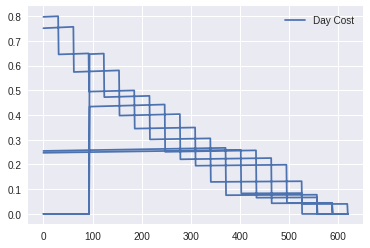

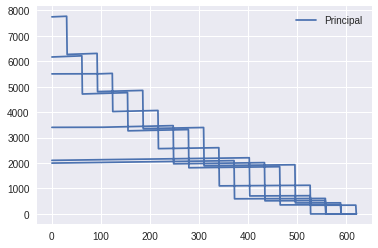

In [38]:
#@title High Rate or High Cost
HIGH_RATE = False #@param {type:"boolean"}

#True = high rate model
#False = high daily cost model
PAYMENT_TIME = 30
MONTH_CROSSOVER = 4 #months until grace period


'''
________________________________________
Instantiate
________________________________________
'''
A = Group("A", .0466, 3400.00, False,0)
B = Group("B", .0466, 1996.08, True,0)
C = Group("C", .0429, 5500.00, False,0)
D = Group("D", .0429, 2103.66, True,0)
E = Group("E", .0376, 7739.26, True,0)
G = Group("G", .0445, 7662.62, True,0)


groups = [A,B,C,D,E,G]
total_principal = 0

# Total Principal
for group in groups:
  total_principal += round(group.principal,2)

active_groups = [group for group in groups if group.active == True]


# Main Munch
month_watch = 0
month_count = 0
# change this to while there is an active group
while any(group.active for group in groups):
  leftover = 0
  if(month_watch == 0):
    leftover = payment_exp_1(active_groups,1500,HIGH_RATE)
    if(leftover != 0):
      payment_exp_1(active_groups,leftover, HIGH_RATE)
    for group in groups:
      group.record()
    month_watch = PAYMENT_TIME
    month_count +=1
    if(month_count == MONTH_CROSSOVER):
      active_groups = groups
      for group in groups:
        group.active = True
  else:
    for group in groups:
      group.record()
    month_watch -=1

histories = [A.history, B.history,C.history, D.history,E.history,G.history]
plt.figure()
concated = pd.concat(histories)

concated.plot(y='Day Cost')
concated.plot(y='Principal')
total = 0
for group in groups:
  for payment in group.payments:
    total += payment[1]
    
print("Begining Total: $" + str(total_principal))
print("Amount Paid: $" + str(total))
print("Intrest Paid: " + str(total-total_principal))
print("Months Taken: " + str(month_count))
print("A: " + str(A.done))
print("B: " + str(B.done))
print("C: " + str(C.done))
print("D: " + str(D.done))
print("E: " + str(E.done))
print("G: " + str(G.done))